Иванов Ю.С.
ivanov_ys@icloud.com


Получаем доступ к данным через 
https://ai.leader-id.ru/api/v1/activities/4/leaderboard/?format=json&limit=2000

Сохраняем в LeaderJSON.json

In [1]:
import json
import pandas as pd
from tld import get_tld

import tldextract

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

import difflib

import re
import transliterate
from googletrans import Translator

from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler

In [2]:
file_name = "LeaderJSON.json"
with open(file_name, 'r') as f:
    document =  json.loads(f.read())
    
results=document['results']

data=pd.DataFrame.from_dict(results)
data=data.set_index('id')

In [3]:
print(" ОТВЕТ НА ПЕРВЫЙ ВОПРОС\n")

#были некоторые проблемы с использованием библиотеки tld. например http://github.io извлекались как github.io
#поэтому использовали tldextract

data['TLD']=[tldextract.extract(url)[2] for url in data['link']]
data['Domain']=[tldextract.extract(url)[1] for url in data['link']]

top_three_tld=data.TLD.value_counts()[0:3]

print("Наиболее часто используемые домены:")

for i in range(0,3):
    print(f"{i+1}е место '{top_three_tld.index[i]}' - всего {top_three_tld[i]} записей")

 ОТВЕТ НА ПЕРВЫЙ ВОПРОС

Наиболее часто используемые домены:
1е место 'ru' - всего 502 записей
2е место 'com' - всего 478 записей
3е место 'sk' - всего 45 записей


Для ответа на второй вопрос
переведем все в нижний регистр

In [4]:
data.name=data.name.str.lower()
data.Domain=data.Domain.str.lower()

*ВНИМАНИЕ ДОСТУП ПО id
Необходимо рассмотреть несколько случаев

1 Случай: название сайта входит в текст описания проекта
Например

data.Domain[9] in data.name[9]
True 

In [5]:
print(f"Название сайта:'{data.Domain[9]}', описание сайта:'{data.name[9]}',\
входит:{data.Domain[9] in data.name[9]}")

Название сайта:'emiia', описание сайта:'emiia.ai –  neural network library for signal processing and data visualization',входит:True


2 Случай: название сайта состоит из нескольких слов, в которых присутствует название проекта

Например

data.Domain[823] in data.name[823].lower()
False

data.name[823] in data.Domain[823]
False

In [6]:
print(f"Название сайта:'{data.Domain[823]}', описание сайта:'{data.name[823]}',\
входит:{data.Domain[823] in data.name[823]}")

Название сайта:'gogotechnology', описание сайта:'gogo курьер',входит:False


Для обработки такого случая необходимо разбить строку на слова и проверить их вхождение в название сайта

Также необходимо ограничить длину слов до 3

для разбиения по нескольким разделителям используем библиотеку re
re.split(r'[-.;,\s]\s*',data.name[679])

any([word in data.Domain[823] for word in re.split(r'[-.;,\s]\s*',data.name[823]) if len(word)>2])
True 


In [7]:
print(f"Название сайта:'{data.Domain[823]}', описание сайта:'{data.name[823]}',\
входит:{any([word in data.Domain[823] for word in data.name[823].split() if len(word)>2])}")
print(f"Название сайта:'{data.Domain[637]}', описание сайта:'{data.name[637]}',\
входит:{any([word in data.Domain[637] for word in data.name[637].split() if len(word)>2])}")

Название сайта:'gogotechnology', описание сайта:'gogo курьер',входит:True
Название сайта:'wwmarketingbot', описание сайта:'ww marketing bot',входит:True


3 Случай: Название написано на русском языке, название сайта на английском или в латинице необходимо выполнить перевод или транслитерацию в латиницу

In [8]:
def domain_is_match_name(name:str, domain:str)->bool:
    result=(any([word in domain for word in re.split(r'[-.;,\s]\s*',name) if len(word)>2]) or
            name in domain or
            any([word in name for word in re.split(r'[-.;,\s]\s*',domain) if len(word)>2]))

    return result

# translator = Translator()
# translator.translate(data.name[20]).text    

In [9]:
print(" ОТВЕТ НА ВТОРОЙ ВОПРОС\n")
data['domain_match_name']=[domain_is_match_name(name,domain) for(name,domain) in zip(data.name,data.Domain)]

print (f"У {(data['domain_match_name'] == True).sum()} проектов их название совпадает с названием их сайта \n\
(учитываются только приобретенные домены. субдомены не учитываются) ")

 ОТВЕТ НА ВТОРОЙ ВОПРОС

У 162 проектов их название совпадает с названием их сайта 
(учитываются только приобретенные домены. субдомены не учитываются) 


 ОТВЕТ НА ТРЕТИЙ ВОПРОС


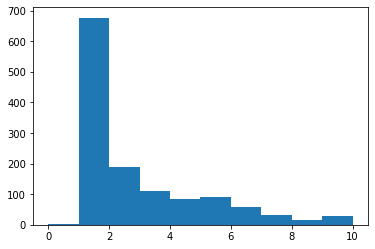

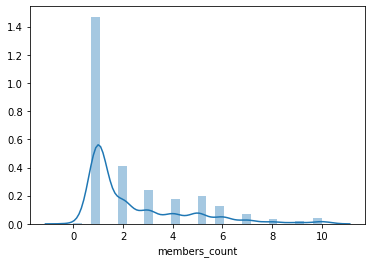

In [10]:
labels=data['members_count'].value_counts(sort=False).index.values
plt.hist(data['members_count'])

fig, ax =plt.subplots()
#sns.distplot(data['members_count'],norm_hist = False, kde=False, bins=[1, 2, 3, 4, 5, 6, 7,8,9], ax=ax[0])
sns.distplot(data['members_count'],norm_hist = True, kde=True)

print(" ОТВЕТ НА ТРЕТИЙ ВОПРОС")

На графиках видно, что максимальное количество команд состоит из одного человека

In [11]:
data['members_count'].value_counts(sort=False)

0       4
1     677
2     189
3     112
4      83
5      90
6      57
7      31
8      17
9      11
10     19
Name: members_count, dtype: int64

Попробуем найти зависимость между результатами команды и количеством человек в ней

<BarContainer object of 22 artists>

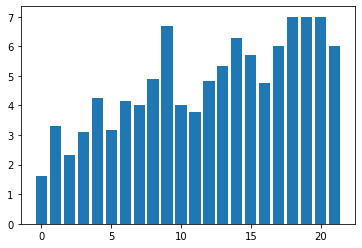

In [12]:
team_results=data['features_count'].value_counts(sort=False).rename('number_of_teams').to_frame()

team_results['average_members'] = [(data.loc[data['features_count']==score]).members_count.mean() for score in team_results.index.values]
plt.bar(team_results.index,team_results['average_members'].values)

На диаграмме представлен Score команд (Ox) количество участников (Oy)
Можно предположить, что команды с количеством участников не менее 3х достигают больших результатов

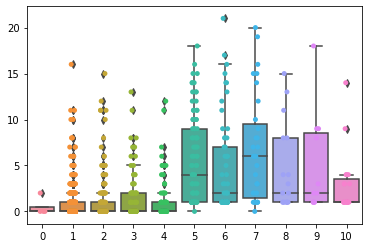

In [13]:
sns.stripplot(data['members_count'].values,data['features_count'].values)
sns.boxplot(data['members_count'].values,data['features_count'].values)

При этом команды от 5 человек не имеют нулевого score
развернув график видно, что наиболее эффективные команды от 3 до 6-7 человек

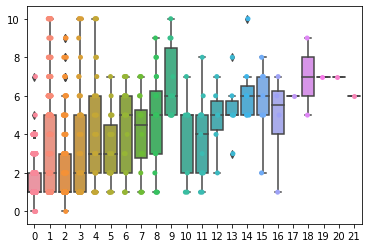

In [14]:
sns.stripplot(data['features_count'].values,data['members_count'].values)
sns.boxplot(data['features_count'].values,data['members_count'].values)


Однако, вычисляя обычную корреляцию, мы получаем довольно низкое значение

In [15]:
pearsonr(data['members_count'].values,data['features_count'].values)    # Pearson's r

(0.44144376797751905, 1.1952234288606163e-62)

In [16]:
spearmanr(data['members_count'].values,data['features_count'].values)   # Spearman's rho

SpearmanrResult(correlation=0.41178196176234744, pvalue=5.80282991918898e-54)

In [17]:
kendalltau(data['members_count'].values,data['features_count'].values)  # Kendall's tau

KendalltauResult(correlation=0.34181361714880243, pvalue=1.2406978214796824e-48)

Проведем кластеризацию
эмпирически пришли к 6 кластерам


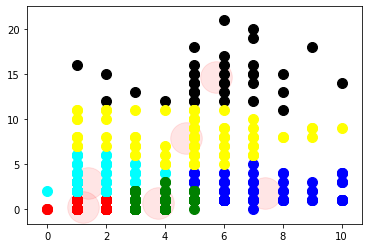

In [18]:
points= np.array([data['members_count'].values,data['features_count'].values]).T

scaler = MinMaxScaler()

scaler.fit(points)
# points=scaler.transform(points)

kmeans = KMeans(n_clusters=6)# fit kmeans object to data
kmeans.fit(points)# print location of clusters learned by kmeans object
center=kmeans.cluster_centers_# save new clusters for chart
y_km = kmeans.fit_predict(points)
plt.scatter(center[:,0],center[:,1], s = 1000,c = [[1, 0, 0, 0.1]])


plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=100, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=100, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=100, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=100, c='cyan')
plt.scatter(points[y_km ==4,0], points[y_km == 4,1], s=100, c='yellow')
plt.scatter(points[y_km ==5,0], points[y_km == 5,1], s=100, c='green')

На графике отмечены кластеры и их центры (персиковые круги)
как и в предидущем случае видно,то наибольшая эффективность достигается при 5-6 членах команды

ВЫВОД
Считаю, что идеальный вариант посмотреть во времени.
Нужно рассмотреть вопрос:
Как менялось место (Score) команды после добавления участников
Тут можно даже подумать об анализе временных рядов и применении различных методов машинного обучения.
На данный момент данных достаточно мало, для того, чтобы сделать полноценный вывод